# Using a SageMaker Built in Algorithm

***Anomaly detection using Random Cut Forest (RCF) algorithm.***

---

*This notebook should be deployed in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel in the Oregon (us-west-2) region for the hyperllinks to the console to work correctly* 

## Introduction
***



Amazon SageMaker Random Cut Forest (RCF) is an algorithm designed to detect anomalous data points within a dataset. It is a variant of the Cut Forest algorithm, adapted by AWS, that is avaialbe in the sagemaker python library. In this notebook, we will demonstrate the simplicity of using RCF to detect anomalies in the [Numenta Anomaly Benchmark (NAB) NYC Taxi dataset](https://github.com/numenta/NAB/blob/master/data/realKnownCause/nyc_taxi.csv), which records the amount New York City taxi ridership over the course of six months.

The goal of this demo is to show how easy it is to utilize a built in SageMaker algorithm. As such, this notebook might not cover the full scope of the analysis that would be possible on this dataset.

To gain deeper insight into the RCF algorithm please refer to the [SageMaker RCF Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html).

## Setup the libraries

***

First we will import the libraries required to process the code:

* boto3 - AWS SDK for Python
* botocore - Boto3 core functionalities
* sagemaker - The SageMaker Python SDK
* sys - Python System-specific runtimes
* pandas - Python data analysis and manipulation tool - used to create the dataframe that we will be working/visualizing from
* matplotlib - a Python visualizations library


In [1]:
import boto3
import botocore
import sagemaker
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

### Define the Output S3 Bucket

In this scenario we will be using [the default SageMaker S3 bucket](https://s3.console.aws.amazon.com/s3/buckets?region=us-west-2&region=us-west-2), however feel free to change the destination bucket and prefix. The bucket is used to deliver the 

In [2]:
bucket = (
    sagemaker.Session().default_bucket()
)
prefix = "sagemaker/rcf-demo"
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name
print(f"Training input/output will be stored in: s3://{bucket}/{prefix}")

Training input/output will be stored in: s3://sagemaker-us-west-2-656165796789/sagemaker/rcf-demo


### Define the Training data S3 Bucket

Define the training data source bucket

In [3]:
downloaded_data_bucket = f"sagemaker-sample-files"
downloaded_data_prefix = "datasets/tabular/anomaly_benchmark_taxi"
print(f"Downloaded training data will be read from s3://{downloaded_data_bucket}/{downloaded_data_prefix}")

Downloaded training data will be read from s3://sagemaker-sample-files/datasets/tabular/anomaly_benchmark_taxi


### Define and Visualize the Example Data

The sample data provided with this notebook (NAB_nyc_taxi.csv) consists of the number of New York City taxi passengers over the course of six months aggregated into 30-minute buckets. Within the data there are anomalous events occurring during the NYC marathon, Thanksgiving, Christmas, New Year's day, and on the day of a snow storm. 

Human beings are visual creatures and are able to very quickly identify anomalies when the data is visualised. 

In the next set of code we read the NAB_nyc_taxi.csv to create a dataframe using Pandas, and visualise the dataset with matplotlib, to see if we can spot some anomalies.

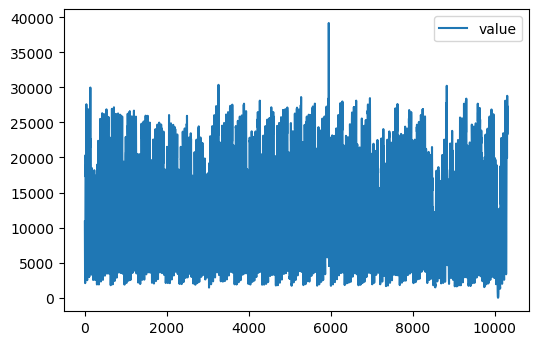

In [4]:
data_filename = "NAB_nyc_taxi.csv"
taxi_data = pd.read_csv(data_filename, delimiter=",")

%matplotlib inline
matplotlib.rcParams["figure.dpi"] = 100
taxi_data.plot()

With taxi ridership, the passenger count appears more or less periodic, however we can easily identify an anomaly at around datapoint number 6000. However, due to the nature of the human brain we tend to focus in on the very obvious anomalies, but are unable to detect any anomalies hidden to the huma eye.

This is where the SageMaker RCF algorithm can really make a difference. 

## Training Using RCF

***

Import the built in RCF algorithm from the sagemaker python library

In [5]:
from sagemaker import RandomCutForest

Set up the training parameters:

* **`role=execution_role`** - we are using the instance session role, however a custom role can be specified here
* **`instance_count=1`** - number of instances for training
* **`instance_type="ml.c5.4xlarge"`** - type and size of the SageMaker training instance 
* **`data_location=f"s3://{bucket}/{prefix}/"`** - the output bucket defined in step XXX
* **`output_path=f"s3://{bucket}/{prefix}/output"`** - the output bucket path

  * Recommended instance type: `ml.m5.large` or `ml.c5.xlarge`
  * The RCF algorithm does not take advantage of GPU hardware.

Set up the hyperparameters:

* **`num_samples_per_tree`** - the number randomly sampled data points sent to each tree. As a general rule, `1/num_samples_per_tree` should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **`num_trees`** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.



In [6]:
sagemaker_session = sagemaker.Session()

rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_samples_per_tree=512,
    num_trees=50,
)

Run the training job - this should take about 3 minutes using an `ml.c5.xlarge` instance. - the status of the endpoint can be observed in the [SageMaker Console - Training Jobs](https://us-west-2.console.aws.amazon.com/sagemaker/home?region=us-west-2#/jobs)

In [7]:
rcf.fit(rcf.record_set(taxi_data.value.to_numpy().reshape(-1, 1)))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-06-20 16:23:55 Starting - Starting the training job...
2022-06-20 16:24:19 Starting - Preparing the instances for trainingProfilerReport-1655742235: InProgress
......
2022-06-20 16:25:19 Downloading - Downloading input data...
2022-06-20 16:25:39 Training - Downloading the training image...
2022-06-20 16:26:19 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/20/2022 16:26:25 INFO 140504422410048] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 8999}
[06/20/2022 16:26:25 INFO 140504422410048] Merg

## Inference Using RCF

***

Now that we have a trained RCF model we can deploy a SageMaker endpoint to compute anomaly scores from our example data.

To deploy the endpoint simply use th SageMaker Python SDK `deploy()` function from the model that was created in the training job. We only need to define the number of instances and the instance type for inference. The recommended  using the `ml.c5.large` instance type as it provides the fastest inference time at the lowest cost.

Note: 
  * The default quota for your account might only allow the use of `ml.m5.large` instances for the endpoint deployment.
  
This process should take about 3 minutes - the status of the endpoint can be observed in the [SageMaker Console - Endpoints](https://us-west-2.console.aws.amazon.com/sagemaker/home?region=us-west-2#/endpoints)

In [8]:
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge")
print(f"Endpoint name: {rcf_inference.endpoint_name}")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


----!Endpoint name: randomcutforest-2022-06-20-16-27-07-615


To pass the training dataset to the endpoint we need to convert the CSV format to JSON. We can use the SageMaker serializer and deserializer, that can automatically take care of the datatype conversion from Numpy NDArrays.

In [9]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

Next we need to run the inference on the data set and create the anomaly scores.

In [10]:
taxi_data_numpy = taxi_data.value.to_numpy().reshape(-1, 1)
results = rcf_inference.predict(taxi_data_numpy)
scores = [datum["score"] for datum in results["scores"]]

Finally we can plot the anomaly scores to the dataframe we created earlier and visualise the inference results to find andy hidden anomalies.

(0.6690272807, 6.572324932879999)

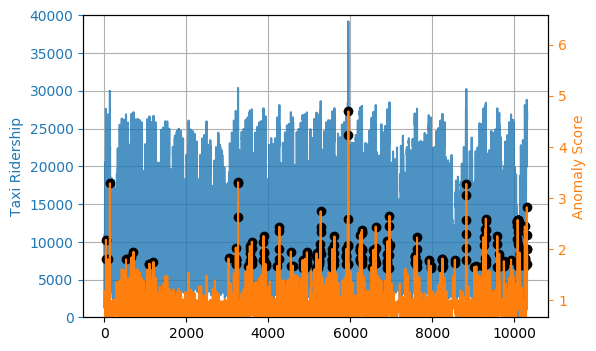

In [11]:
taxi_data["score"] = pd.Series(scores, index=taxi_data.index)
score_mean = taxi_data["score"].mean()
score_std = taxi_data["score"].std()
score_cutoff = score_mean + 3 * score_std
start, end = 0, len(taxi_data)
taxi_data_subset = taxi_data[start:end]
anomalies = taxi_data_subset[taxi_data_subset["score"] > score_cutoff]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.plot(anomalies.index, anomalies.score, "ko")
ax1.plot(taxi_data_subset["value"], color="C0", alpha=0.8)
ax2.plot(taxi_data_subset["score"], color="C1")
ax1.grid(which="major", axis="both")
ax1.set_ylabel("Taxi Ridership", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4 * max(scores))

As you can see, using the RCF inference we are able to identify many additional anomalies in the dataset, that we would not be able to identify in a traditional visualisation.

### Remove the SageMaker Inference Endpoint

To clean up, please uncomment the code below and run it to delete the endpoint.

In [12]:
#sagemaker.Session().delete_endpoint(rcf_inference.endpoint_name)